cuda
(135587, 8)
(135587,)
[6.48000000e+04 6.48540000e+04 6.46851700e+04 1.86693905e+03
 1.04698422e+08 2.75170000e+04 1.17949386e+03 5.56839455e+07]
64800.0
[28241.95 28764.23 28130.       0.       0.       0.       0.       0.  ]
28235.47


/tmp/ipykernel_8906/1228039795.py:48: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(2, 2, 1)


KeyboardInterrupt: 

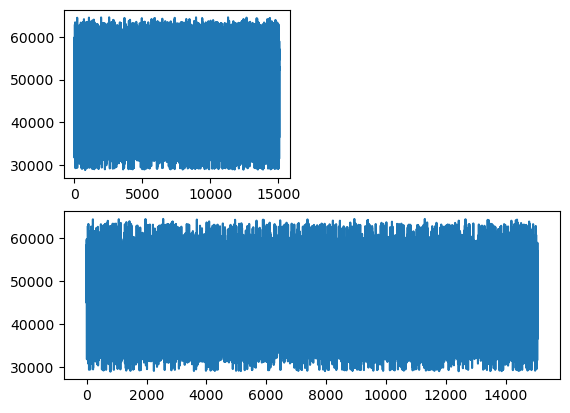

In [28]:
import torch
from sklearn.model_selection import train_test_split
from dataset import BitcoinRegressionDataset
from dataset import BitcoinRegressionDataset_train
from network import network
import csv
import numpy as np
from dataset import max_min
from matplotlib import pyplot as plt

x ,y = [],[]
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
with open("Bitcoin Price (USD).csv") as csv_file:
    csv_reader = csv.reader(csv_file, delimiter=';')
    next(csv_reader)
    for row in csv_reader:
        #print(row)
        y.append(float(row[4])) #saidas
        x.append([float(row[1]),float(row[2]),float(row[3]),float(row[5]),float(row[7]),float(row[8]),float(row[9]),float(row[10])]) #features que queremos (entradas)
"""
N = len(y) #Numero total de exemplos

train_x = x[:int(N*0.8)] #8 linhas, do 80% do total de colunas
print(train_x)
train_y = y[:int(N*0.8)]

val_x = x[int(N*0.8):int(N*0.9)]
val_y = y[int(N*0.8):int(N*0.9)]

test_x = x[int(N*0.9):]
test_y = y[int(N*0.9):]

"""
train_x, test_x, train_y, test_y = train_test_split(x, y, test_size=0.2, random_state=0)

train_x, val_x, train_y, val_y = train_test_split(train_x, train_y, test_size=0.1, random_state=0)

x_max,x_min,y_max,y_min = max_min(train_x,train_y)

"""
plt.subplot(2, 1, 1)
plt.plot(train_y)

plt.subplot(2, 1, 2)
plt.plot(val_y)

plt.subplot(2, 2, 1)
plt.plot(val_y)
"""

trainset = BitcoinRegressionDataset_train(train_x,train_y,x_max,x_min,y_max,y_min) #matriz com dados normalizados

data_loader_train = torch.utils.data.DataLoader( #Otimizar a maneira como le as coisas
    trainset,
    batch_size=16,
    shuffle=True,
    drop_last=True,
    num_workers=8,
)

valset = BitcoinRegressionDataset(val_x,val_y,x_max,x_min,y_max,y_min) #matriz com os dados de validacao

data_loader_val = torch.utils.data.DataLoader(
    valset,
    batch_size=16,
    shuffle=True,
    drop_last=True,
    num_workers=8,
)

testset = BitcoinRegressionDataset(test_x,test_y,x_max,x_min,y_max,y_min) #matrix com dados para teste

data_loader_test = torch.utils.data.DataLoader(
    testset,
    batch_size=16,
    shuffle=True,
    drop_last=True,
    num_workers=8,
)

network = network(8,256,256) #Número features , 2 camadas com 256 neuronios

network = network.to(device)


optimizer = torch.optim.Adam(network.parameters(), lr=3e-4) #lr = learning rate, parametros para otimizar arede

criterion = torch.nn.MSELoss() #função de treino 

for epoch in range(100):
    train_loss = 0
    val_loss = 0
    for x,y in data_loader_train:
        x = x.to(device)
        y = y.to(device)
        optimizer.zero_grad() #reset gráfico do gradiente
        y_pred = network(x) #previsão da rede para este x
        loss = criterion(y,y_pred) #diferença entre o que devia ter previsto e o que rede preveu 
        loss.backward() #para calcular o gradiente
        optimizer.step() #atualizar os pesos

        train_loss += loss.item()
    
    for x,y in data_loader_val: 
        x = x.to(device)
        y = y.to(device)      
        y_pred = network(x)
        loss = criterion(y,y_pred)
        

        val_loss += loss.item()
    
    train_loss = train_loss / len(train_y)
    val_loss = val_loss / len(val_y)

    print(f"Epoch {epoch+1}/100 : Train loss = {train_loss} | Val loss = {val_loss}")

test_loss = 0
for x,y in data_loader_test:
    x = x.to(device)
    y = y.to(device)       
    y_pred = network(x)
    loss = criterion(y,y_pred)

    test_loss += loss.item()

test_loss = test_loss / len(test_y)

print(f"Test loss = {test_loss}")
        
torch.save(network.state_dict(), "network_RMSE_2Lay_256_Linear_" + test_loss +"_.tar")

